# 📂 Task 1: Information Extraction & Knowledge Graph Construction

### 📝 Overview
We transformed raw, semi-structured SAP technical documents (**KBAs**) into a structured **Knowledge Graph**. 
* **Goal:** Turn a "messy manual" (JSON + HTML) into a visual map connecting problems to products, error codes, and solutions.
* **Result:** A network that makes it easier for AI to understand the "web" of SAP issues.

---

### 🛠️ Tech Stack & Libraries
| Library | Purpose |
| :--- | :--- |
| **`BeautifulSoup (bs4)`** | Cleans & strips HTML tags (`<p>`, `<li>`) from raw text. |
| **`LangChain`** | Uses `RecursiveCharacterTextSplitter` to intelligently chunk long docs. |
| **`Spacy`** | Industrial-strength NLP for **Named Entity Recognition (NER)**. |
| **`NetworkX`** | Mathematically constructs the Graph nodes and edges. |
| **`Matplotlib`** | Visualizes and plots the final network diagram. |

---

### 🚀 Workflow: From JSON to Graph
1.  **Ingestion:** Load raw SAP KBA file (`.json`).
2.  **Cleaning:** Extract "Symptom", "Cause", and "Resolution" from HTML.
3.  **Chunking:** Split text into semantic pieces (approx 1000 chars) to preserve context.
4.  **Extraction:** Identify **Entities** (Products) and **Relationships** (References).
5.  **Graphing:** Connect data points into a network diagram.

---

### 🧠 Technical Logic & Solutions

#### 1. Handling Semi-Structured Data
* **Problem:** Input is JSON, but text fields contain HTML tags.
* **Solution:** parsed with **BeautifulSoup** to get pure text. Concatenated `Symptom` + `Cause` + `Resolution` for full context.

#### 2. Semantic Text Splitting
* **Problem:** Long technical documents confuse NLP models.
* **Solution:** Used **LangChain's** `RecursiveCharacterTextSplitter` (`chunk_size=1000`). It keeps paragraphs together, preserving meaning unlike simple line splitting.

#### 3. Named Entity Recognition (NER)
* **Problem:** Identifying specific SAP terms (e.g., "HANA", "ABAP").
* **Solution:** Applied **Spacy** (`en_core_web_sm`) to filter for `ORG` (Product/Company) and `PRODUCT` labels.

#### 4. Hybrid Relationship Extraction
* **Implicit:** Text mentions "HANA" $\rightarrow$ Link Document to Entity `HANA`.
* **Explicit:** Metadata field `references` lists ID `2399993` $\rightarrow$ Link Document to Document `2399993`.

---

### 📊 Graph Visualization Legend
We used **NetworkX** to build a **LightRAG**-inspired graph:

* 🔴 **Red Nodes:** Source Document (The KBA).
* 🔵 **Blue Nodes:** Entities (Keywords like "HANA", "SQL").
* 🟢 **Green Nodes:** Referenced Documents (Linked SAP Notes).
* ➖ **Edges:** Represents the flow (e.g., `Doc A` $\rightarrow$ *mentions* $\rightarrow$ `Entity B`).

> **Key Takeaway:** This pipeline successfully converts unstructured text into a structured, queryable network without crashing memory, thanks to LangChain's efficient splitting.

In [15]:
import json
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import spacy
from langchain_text_splitters import RecursiveCharacterTextSplitter



In [18]:
# Load NLP model
nlp = spacy.load("en_core_web_sm")

In [6]:
def load_sap_kba(file_path):
    """
    Loads the JSON file.
    Logic: Uses standard json library to parse the semi-structured format.
    """
    with open(file_path, 'r', encoding='utf-8') as f:
        data = json.load(f)
    return data

In [7]:
def preprocess_kba_content(kba_data):
    """
    Extracts and cleans text from the HTML 'texts' sections.
    Logic: 
    1. Iterates through the 'texts' list (Symptom, Cause, Resolution).
    2. Uses BeautifulSoup to strip HTML tags, which are prevalent in SAP KBAs.
    3. Concatenates sections into a single readable string.
    """
    cleaned_text = ""
    if 'texts' in kba_data and kba_data['texts']:
        for section in kba_data['texts']:
            title = section.get('title', 'Unknown Section')
            html_content = section.get('text', '')
            
            # Remove HTML tags
            soup = BeautifulSoup(html_content, "html.parser")
            text_content = soup.get_text(separator=" ", strip=True)
            
            cleaned_text += f"{title}:\n{text_content}\n\n"
    
    return cleaned_text

In [8]:
def apply_text_splitting(text):
    """
    Splits text using modern LangChain.
    Logic: 
    1. Uses RecursiveCharacterTextSplitter to handle large technical documents.
    2. Splits by paragraphs/newlines first to preserve semantic structure.
    """
    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=1000,
        chunk_overlap=100,
        separators=["\n\n", "\n", " ", ""]
    )
    chunks = text_splitter.split_text(text)
    return chunks

In [19]:
def extract_entities(text_chunks):
    """
    Extracts entities using SpaCy.
    Logic: 
    1. Processes text chunks to find organizations (often products), dates, and GPEs.
    2. Filters for likely technical terms (ORG, PRODUCT).
    """
    entities = []
    # Process only the first few chunks to save time for demonstration
    for chunk in text_chunks[:5]: 
        doc = nlp(chunk)
        for ent in doc.ents:
            if ent.label_ in ['ORG', 'PRODUCT', 'GPE']:
                entities.append((ent.text, ent.label_))
    
    # Remove duplicates
    return list(set(entities))

In [11]:
def extract_relationships(kba_data):
    """
    Identifies relationships from the metadata.
    Logic: 
    1. SAP KBAs have a dedicated 'references' list containing linked SAP Notes/KBAs.
    2. This function extracts the target ID and the title of the referenced document.
    """
    relationships = []
    source_id = str(kba_data.get('_id'))
    
    if 'references' in kba_data and kba_data['references']:
        for ref in kba_data['references']:
            target_id = ref.get('grObjId')
            ref_title = ref.get('grObjRefTitle')
            # 'grDefTitle' usually describes the type (e.g., 'SAP Knowledge Base Articles')
            rel_type = ref.get('grDefTitle', 'Reference') 
            
            if target_id:
                relationships.append({
                    "source": source_id,
                    "target": target_id,
                    "type": rel_type,
                    "target_label": ref_title
                })
    return relationships

In [12]:
def build_knowledge_graph(kba_data, entities, relationships):
    """
    Constructs a graph using NetworkX.
    Logic:
    1. Central Node: The current KBA.
    2. Entity Nodes: Extracted terms (products, companies) linked via 'MENTIONS'.
    3. Document Nodes: Referenced SAP Notes linked via 'REFERENCES'.
    """
    G = nx.DiGraph()
    
    # Add Central Node
    doc_id = str(kba_data.get('_id'))
    doc_title = kba_data.get('shortText', 'Untitled KBA')
    G.add_node(doc_id, label=doc_title, type='KBA', color='red')
    
    # Add Entity Nodes and Edges
    for entity, ent_type in entities:
        G.add_node(entity, label=entity, type=ent_type, color='blue')
        G.add_edge(doc_id, entity, relation='MENTIONS')
    
    # Add Reference Nodes and Edges
    for rel in relationships:
        target_id = rel['target']
        # Truncate title for cleaner graph visualization
        target_label = (rel['target_label'][:20] + '...') if rel['target_label'] else target_id
        
        G.add_node(target_id, label=target_label, type='Reference', color='green')
        G.add_edge(doc_id, target_id, relation='REFERENCES')
        
    return G

Graph Nodes: 368
Graph Edges: 367


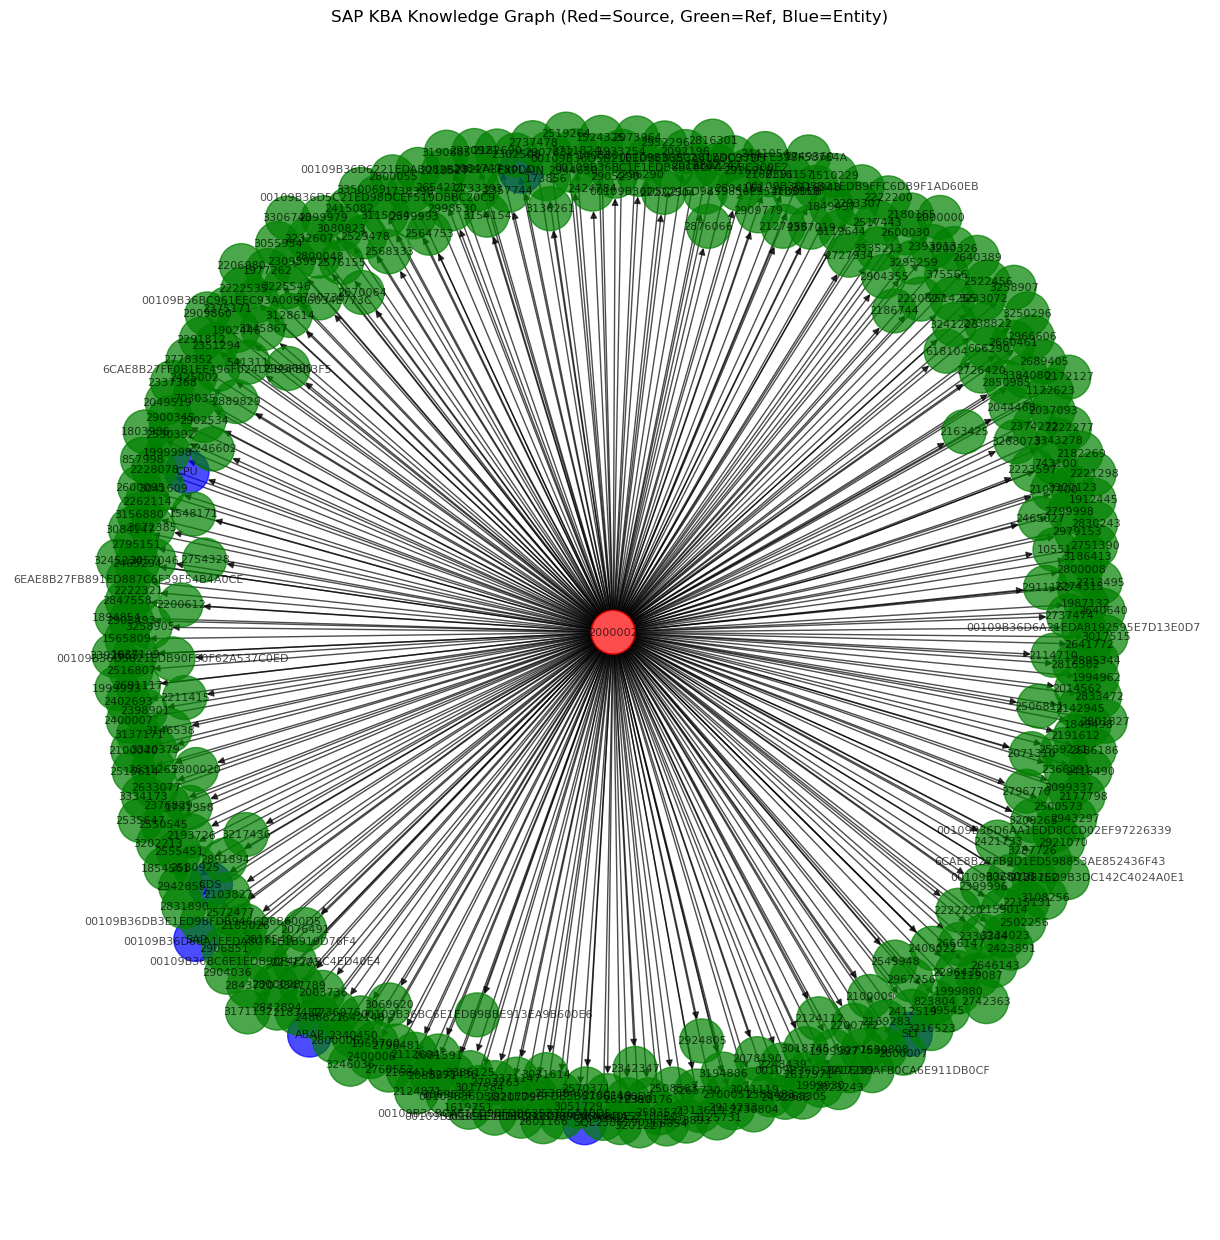

In [20]:
# --- Execution ---
file_path = '2000002.json' 

# 1. Load
data = load_sap_kba(file_path)

# 2. Preprocess & Split
clean_text = preprocess_kba_content(data)
chunks = apply_text_splitting(clean_text)

# 3. Extract Entities (NER)
extracted_ents = extract_entities(chunks)

# 4. Extract Relationships (Metadata)
extracted_rels = extract_relationships(data)

# 5. Build Graph
kg = build_knowledge_graph(data, extracted_ents, extracted_rels)

# --- Visualization (Optional) ---
print(f"Graph Nodes: {kg.number_of_nodes()}")
print(f"Graph Edges: {kg.number_of_edges()}")

# Simple draw
pos = nx.spring_layout(kg, k=0.5)
colors = [nx.get_node_attributes(kg, 'color').get(node, 'grey') for node in kg.nodes()]

plt.figure(figsize=(12, 12))
nx.draw(kg, pos, with_labels=True, node_color=colors, font_size=8, node_size=1000, alpha=0.7)
plt.title("SAP KBA Knowledge Graph (Red=Source, Green=Ref, Blue=Entity)")
plt.show()